<a href="https://colab.research.google.com/github/akshala/Assembler/blob/master/LSTM_initial_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize']=15,10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving mimic.csv to mimic.csv


In [94]:
# load data from csv
data = pd.read_csv("mimic.csv", index_col="Timestamp")
data

,X.HR.,X.PULSE.,X.RESP.,X.SpO2.,SI_by_abp,final_abp_sys,final_abp_dias,label
Timestamp,,,,,,,,
2108-11-23 04:09:00,71.2,71.1,20.1,92.3,0.549383,129.600000,45.900000,1
2108-11-23 04:10:00,75.2,74.9,24.5,92.0,0.588880,127.700000,46.000000,1
2108-11-23 04:11:00,81.7,82.3,20.6,92.2,0.614748,132.900000,48.100000,1
2108-11-23 04:12:00,84.3,84.5,14.9,92.8,0.639121,131.900000,48.400000,1
2108-11-23 04:13:00,78.6,77.2,19.7,92.4,0.604615,130.000000,47.300000,1
...,...,...,...,...,...,...,...,...
2181-08-09 02:11:00,67.0,66.0,19.0,97.0,0.621790,107.753474,63.134797,0
2181-08-09 02:12:00,67.0,65.0,21.0,97.0,0.621790,107.753474,63.134797,0
2181-08-09 02:13:00,67.0,66.0,22.0,98.0,0.621790,107.753474,63.134797,0


In [95]:
 data.dtypes

X.HR.             float64
X.PULSE.          float64
X.RESP.           float64
X.SpO2.           float64
SI_by_abp         float64
final_abp_sys     float64
final_abp_dias    float64
label               int64
dtype: object

In [96]:
columns = ["X_HR", "X_PULSE", "X_RESP", "X_SpO2", "SI_by_abp", "final_abp_sys", "final_abp_dias", "label"]

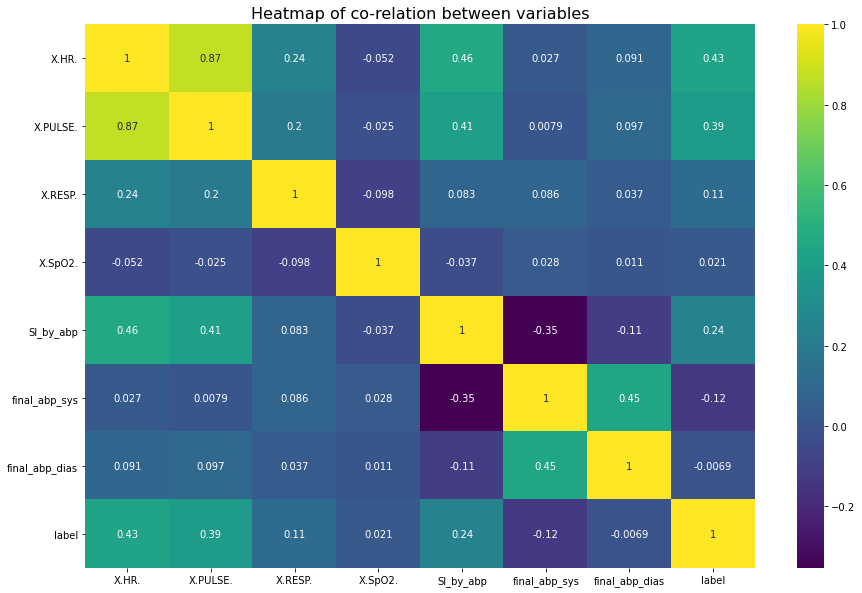

In [98]:
#Use heatmap to see corelation between variables
sns.heatmap(data.corr(), annot=True, cmap='viridis')
plt.title('Heatmap of co-relation between variables',fontsize=16)
plt.show()



In [8]:
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense
from keras.layers import LSTM
import glob
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


In [99]:
total_number_rows = 443904
num_files = 1734
label = data["label"]
data.reset_index(drop=True, inplace=True)
print(data)

        X.HR.  X.PULSE.  X.RESP.  ...  final_abp_sys  final_abp_dias  label
0        71.2      71.1     20.1  ...     129.600000       45.900000      1
1        75.2      74.9     24.5  ...     127.700000       46.000000      1
2        81.7      82.3     20.6  ...     132.900000       48.100000      1
3        84.3      84.5     14.9  ...     131.900000       48.400000      1
4        78.6      77.2     19.7  ...     130.000000       47.300000      1
...       ...       ...      ...  ...            ...             ...    ...
443899   67.0      66.0     19.0  ...     107.753474       63.134797      0
443900   67.0      65.0     21.0  ...     107.753474       63.134797      0
443901   67.0      66.0     22.0  ...     107.753474       63.134797      0
443902   66.0      65.0     19.0  ...     107.753474       63.134797      0
443903   67.0      66.0     16.5  ...     107.753474       63.134797      0

[443904 rows x 8 columns]


In [100]:
no_nan_data = pd.DataFrame()
i = 0
while i < total_number_rows:
  if not data[i:i+256].isnull().values.any():
    no_nan_data = no_nan_data.append(data[i:i+256])
  i += 256
print(no_nan_data)

        X.HR.  X.PULSE.  X.RESP.  ...  final_abp_sys  final_abp_dias  label
0        71.2      71.1     20.1  ...     129.600000       45.900000      1
1        75.2      74.9     24.5  ...     127.700000       46.000000      1
2        81.7      82.3     20.6  ...     132.900000       48.100000      1
3        84.3      84.5     14.9  ...     131.900000       48.400000      1
4        78.6      77.2     19.7  ...     130.000000       47.300000      1
...       ...       ...      ...  ...            ...             ...    ...
443899   67.0      66.0     19.0  ...     107.753474       63.134797      0
443900   67.0      65.0     21.0  ...     107.753474       63.134797      0
443901   67.0      66.0     22.0  ...     107.753474       63.134797      0
443902   66.0      65.0     19.0  ...     107.753474       63.134797      0
443903   67.0      66.0     16.5  ...     107.753474       63.134797      0

[382976 rows x 8 columns]


In [101]:
df = no_nan_data.values.tolist()
df

[[71.2, 71.1, 20.1, 92.3, 0.5493827160493829, 129.6, 45.9, 1.0],
 [75.2, 74.9, 24.5, 92.0, 0.5888801879404849, 127.7, 46.0, 1.0],
 [81.7, 82.3, 20.6, 92.2, 0.6147479307750191, 132.9, 48.1, 1.0],
 [84.3, 84.5, 14.9, 92.8, 0.6391205458680821, 131.9, 48.4, 1.0],
 [78.6, 77.2, 19.7, 92.4, 0.604615384615385, 130.0, 47.3, 1.0],
 [84.3, 85.6, 26.6, 92.0, 0.628635346756152, 134.1, 50.1, 1.0],
 [75.6, 74.5, 18.7, 92.1, 0.581986143187067, 129.9, 44.2, 1.0],
 [76.2, 77.6, 21.6, 91.5, 0.5939204988308651, 128.3, 45.8, 1.0],
 [76.2, 75.5, 20.2, 91.3, 0.5794676806083651, 131.5, 47.1, 1.0],
 [81.6, 82.1, 18.4, 93.8, 0.5951859956236321, 137.1, 52.2, 1.0],
 [82.7, 82.9, 19.4, 93.1, 0.616703952274422, 134.1, 50.9, 1.0],
 [83.7, 83.7, 19.7, 93.3, 0.631698113207547, 132.5, 49.5, 1.0],
 [82.9, 81.8, 22.1, 93.0, 0.6357361963190179, 130.4, 48.3, 1.0],
 [71.5, 72.7, 25.3, 92.7, 0.547473200612557, 130.6, 46.3, 1.0],
 [79.6, 79.0, 24.1, 92.4, 0.603945371775417, 131.8, 47.8, 1.0],
 [75.8, 74.9, 24.8, 92.3, 0.5694

In [102]:
len(df[0])

8

In [103]:
total_number_rows = 382976
X = []
i = 0
while i < total_number_rows:
  X.append(list(df[i:i+256]))
  i += 256

In [104]:
X = np.array(X)

In [105]:
X.shape

(1496, 256, 8)

In [106]:
np.random.shuffle(X)

In [107]:
print(X[0])

[[101.7 101.5  20.6 ... 152.2  74.9   1. ]
 [102.2 101.7  21.6 ... 151.3  74.5   1. ]
 [103.4 100.7  21.2 ... 150.4  73.7   1. ]
 ...
 [105.7 104.9  28.2 ... 157.9  83.    1. ]
 [105.9 103.1  30.9 ... 157.5  82.6   1. ]
 [105.7 105.8  30.3 ... 158.1  83.3   1. ]]


In [108]:
X[0]
for i in range(0, 256):
  print(X[0][i][7])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [109]:
X.shape

(1496, 256, 8)

In [110]:
label = []
num_files = 1496
for i in range(num_files):
  for j in range(256):
      label.append(int(X[i][j][7]))
print(label)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [111]:
i = 0
Y = []
while i < total_number_rows:
  Y.append(label[i])
  i += 256

In [112]:
Y = np.array(Y)
Y.shape

(1496,)

In [113]:
X = X[:, :, :7]
X.shape

(1496, 256, 7)

In [114]:
x_min = X.min(axis=(0, 1), keepdims=True)
x_max = X.max(axis=(0, 1), keepdims=True)
X = (X - x_min)/(x_max - x_min)

In [115]:
print(X.shape)

(1496, 256, 7)


In [116]:
print(X[0])

[[0.60679923 0.30784708 0.26657997 ... 0.00450079 0.35024322 0.21235632]
 [0.61000641 0.30865191 0.27958388 ... 0.00455394 0.34815844 0.2112069 ]
 [0.61770366 0.30462777 0.27438231 ... 0.00464172 0.34607366 0.20890805]
 ...
 [0.6324567  0.32152918 0.36540962 ... 0.00450963 0.36344684 0.23563218]
 [0.63373958 0.31428571 0.40052016 ... 0.00453132 0.36252027 0.23448276]
 [0.6324567  0.32515091 0.39271782 ... 0.00450345 0.36391012 0.23649425]]


In [117]:
# split into test and train
train_size = int(num_files * 0.8)
test_size = num_files - train_size
print(train_size, test_size)

1196 300


In [118]:
print(Y[train_size:])

[1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1
 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1
 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0
 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1
 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0
 1 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0
 0 1 0 1]


In [119]:
X_train = X[:train_size, :, :]
print(X_train.shape)
X_test = X[train_size:, :, :]
print(X_test.shape)
Y_train = Y[:train_size]
print(Y_train.shape)
Y_test = Y[train_size:]
print(Y_test.shape)

(1196, 256, 7)
(300, 256, 7)
(1196,)
(300,)


In [123]:
import collections

print(collections.Counter(Y_train))
print(collections.Counter(Y_test))

Counter({1: 672, 0: 524})
Counter({1: 167, 0: 133})


In [129]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(1024, activation="relu", input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.SGD(lr=1e-6, decay=1e-4, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1024)              4227072   
_________________________________________________________________
dense_26 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 257       
Total params: 4,489,729
Trainable params: 4,489,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train, epochs=50, verbose=1)
model.summary()

Epoch 1/50
38/38 [==============================] - 452s 12s/step - loss: 0.6923 - accuracy: 0.6697
Epoch 2/50
38/38 [==============================] - 452s 12s/step - loss: 0.6923 - accuracy: 0.6714
Epoch 3/50
38/38 [==============================] - 447s 12s/step - loss: 0.6923 - accuracy: 0.6672
Epoch 4/50
38/38 [==============================] - 436s 11s/step - loss: 0.6923 - accuracy: 0.6664
Epoch 5/50
38/38 [==============================] - 448s 12s/step - loss: 0.6923 - accuracy: 0.6647
Epoch 6/50
38/38 [==============================] - 429s 11s/step - loss: 0.6923 - accuracy: 0.6589
Epoch 7/50
38/38 [==============================] - 433s 11s/step - loss: 0.6923 - accuracy: 0.6530
Epoch 8/50
38/38 [==============================] - 418s 11s/step - loss: 0.6923 - accuracy: 0.6497
Epoch 9/50
38/38 [==============================] - 418s 11s/step - loss: 0.6923 - accuracy: 0.6463
Epoch 10/50
38/38 [==============================] - 409s 11s/step - loss: 0.6922 - accuracy: 0.6430

In [80]:
y_pred = model.predict(X_test)

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [81]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)
cm

array([[ 84,  38],
       [ 37, 141]])

In [82]:
model.score(X_test, Y_test)

0.75

In [83]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(Y_test, y_pred, normalize=True, sample_weight=None)
accuracy

0.75